In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import torch.nn.functional as F
import shap


In [6]:
import torch
import torch.nn as nn
from torchviz import make_dot

# 定义注意力层（需要您提供这个类的实现或者类似的替代）
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # 这里简化了注意力机制的实现
        weights = torch.softmax(self.fc(x), dim=1)
        out = (x * weights).sum(1)
        return out, weights

# 模型类
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        attn_out, attn_weights = self.attention(lstm_out)
        out = self.fc(attn_out)
        return out, attn_weights

# 实例化模型和输入
model = LSTMModel(input_dim=10, hidden_dim=50, num_layers=2, output_dim=5, dropout_prob=0.5)
x = torch.randn(1, 100, 10)  # 示例输入

# 通过模型传递输入以获取输出（仅用于生成计算图）
y, attn_weights = model(x)

# 生成并保存图
dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot.render('model_graph', format='png')

NameError: name '_C' is not defined

In [8]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        # lstm_output: [batch_size, seq_length, hidden_dim]
        attention_scores = self.linear(lstm_output)  # [batch_size, seq_length, 1]
        attention_weights = F.softmax(attention_scores, dim=1)  # 对每个序列进行softmax
        context_vector = attention_weights * lstm_output  # [batch_size, seq_length, hidden_dim]
        context_vector = torch.sum(context_vector, dim=1)  # [batch_size, hidden_dim]
        return context_vector, attention_weights
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,dropout_prob):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)  # 输出层直接连接到分类数量

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)  # [batch_size, seq_length, hidden_dim]
        lstm_out = self.dropout(lstm_out)

        # 注意力层
        attn_out, attn_weights = self.attention(lstm_out)  # 使用注意力层

        # 全连接层
        out = self.fc(attn_out)  # [batch_size, output_dim]
        return out, attn_weights  # 返回输出和注意力权重

In [9]:
def create_sequences(input_data, target_data, sequence_length):
    sequences = []
    target_sequences = []
    for i in range(len(input_data) - sequence_length):
        sequences.append(input_data[i:i+sequence_length])
        target_sequences.append(target_data[i+sequence_length])
    return np.array(sequences), np.array(target_sequences)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs,device):
    best_accuracy = 0.0  # 初始化最佳准确率
    best_model = None  # 初始化最佳模型权重
    best_epoch = 0  # 初始化最佳模型的训练轮次

    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # 由于模型修改为返回一个元组，我们这里仅使用输出
            y_pred, _ = model(X_batch)  # 获取模型的输出和注意力权重
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # 计算平均训练损失
        train_loss /= len(train_loader)

        # 进入评估模式
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred, _ = model(X_val_batch)  # 同样，仅使用输出
                test_loss += criterion(y_val_pred, y_val_batch).item()
                _, predicted = torch.max(y_val_pred.data, 1)
                total += y_val_batch.size(0)
                correct += (predicted == y_val_batch).sum().item()

        # 计算平均验证损失和准确率
        test_loss /= len(val_loader)
        test_accuracy = correct / total

        # 更新最佳模型（如果适用）
        if test_accuracy > best_accuracy:
            best_epoch = epoch
            best_accuracy = test_accuracy
            best_model = model.state_dict()
            torch.save(best_model, 'model/best_model_clean(k=20).pth')

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, '
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, '
              f'Best Epoch: {best_epoch+1}')

    model.load_state_dict(torch.load('model/best_model_clean(k=20).pth'))

# 预测
def predict(model, test_loader,device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred,_ = model(X_batch)
            predictions.append(y_test_pred.cpu().numpy())
    return np.concatenate(predictions, axis=0)

In [10]:
def mark_label(df,k,thresholds):
    #0:stay,1:up，2:down
    # df['m_minus'] = df['avg_price'].rolling(window=k).mean()
    df['m_plus'] = df['avg_price'].shift(-1).rolling(window=k, min_periods=1).mean().shift(-k+1)
    df['l_t'] = (df['m_plus'] - df['avg_price']) / df['avg_price']
    df['label'] = 0
    df.loc[df['l_t'] > thresholds, 'label'] = 1
    df.loc[df['l_t'] < -thresholds, 'label'] = 2

    return df

In [11]:
from pandas import Timedelta

df = pd.read_csv('process_data/total_lob_1s_k10_0.1.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
df = mark_label(df,10,0.1)
# df = df.iloc[:5000]
df['date'] = pd.to_datetime(df['date'])

# # 将time_window列（秒数）转换为timedelta类型
# df['time_window'] = pd.to_timedelta(df['time_window'], unit='s')
# 
# # 将日期和时间窗口相加，得到完整的datetime对象
# df['datetime'] = df['date']  + df['time_window']+Timedelta(hours=8)

df.set_index('time', inplace=True)
df_index = df.index


feature=df[['avg_price','avg_price_change', 'bid_level_diff', 'ask_level_diff',
             'bid_ask_depth_diff','label']]

target=df['label']

In [12]:
label_distribution = df['label'].value_counts()

print(label_distribution)


label
0    2366453
1     852824
2     604188
Name: count, dtype: int64


In [13]:

scaler = StandardScaler()

# 对特征进行标准化
scaled_features = scaler.fit_transform(feature)
sequence_length = 10  # 可以根据需要调整这个值
X, y = create_sequences(scaled_features, target.values, sequence_length)
# 按顺序划分数据集
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# test_size = int(len(X_temp) * 0.2)
# X_val, X_test = X_temp[:test_size], X_temp[test_size:]
# y_val, y_test = y_temp[:test_size], y_temp[test_size:]

# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


batch_size = 64

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
# val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
# val_loader = DataLoader(val_data, batch_size=64)



In [14]:
input_dim = X_train.shape[2]
hidden_dim = 50 # 隐藏层维度
num_layers = 4 # LSTM层的数量
output_dim =  3# 输出维度
dropout_prob = 0.2

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim,dropout_prob)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 用于多分类问题
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [191]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # CUDA设备对象
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# 然后可以将模型和数据发送到选定的设备
model.to(device)

Using GPU


LSTMModel(
  (lstm): LSTM(6, 50, num_layers=4, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (attention): Attention(
    (linear): Linear(in_features=50, out_features=1, bias=True)
  )
  (fc): Linear(in_features=50, out_features=3, bias=True)
)

In [178]:
num_epochs = 5
train_model(model, train_loader,test_loader,criterion, optimizer, num_epochs,device)

Epoch 1/5, Train Loss: 0.4850, Test Loss: 0.5999, Test Accuracy: 0.8026, Best Epoch: 1
Epoch 2/5, Train Loss: 0.4586, Test Loss: 0.6586, Test Accuracy: 0.7739, Best Epoch: 1
Epoch 3/5, Train Loss: 0.4648, Test Loss: 0.6257, Test Accuracy: 0.7991, Best Epoch: 1
Epoch 4/5, Train Loss: 0.6002, Test Loss: 1.0647, Test Accuracy: 0.4311, Best Epoch: 1
Epoch 5/5, Train Loss: 0.5757, Test Loss: 0.8482, Test Accuracy: 0.6300, Best Epoch: 1


In [192]:
model.load_state_dict(torch.load('model/best_model_clean(k=10).pth'))

<All keys matched successfully>

Accuracy: 0.8016


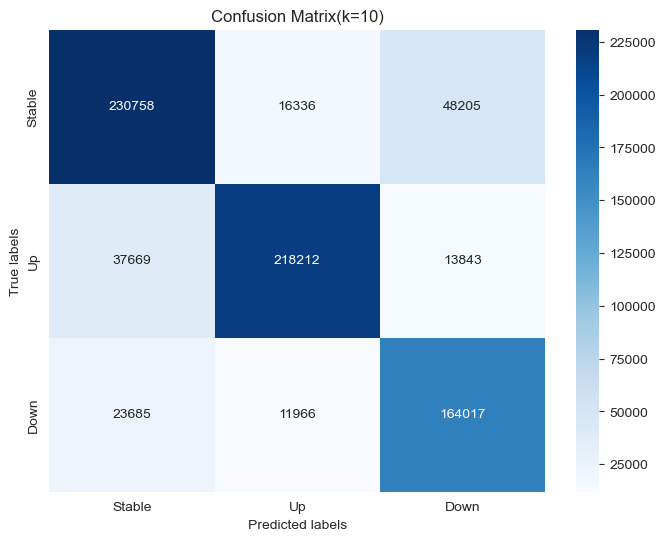

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 测试模型性能# 此函数应该返回模型在测试集上的预测
#model.load_state_dict(torch.load('model/best_model(2).pth'))
predictions = predict(model, test_loader,device)

# 将输出的概率转换为类别索引
_, predicted_classes = torch.max(torch.tensor(predictions), 1)


# 计算准确率
correct_predictions = (predicted_classes == y_test_tensor).sum().item()
accuracy = correct_predictions / y_test_tensor.size(0)
print(f'Accuracy: {accuracy:.4f}')

cm = confusion_matrix(y_test_tensor, predicted_classes.numpy())
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Stable', 'Up', 'Down'], yticklabels=['Stable', 'Up', 'Down'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix(k=10)')
plt.savefig('model/confusion_matrix(k=10).png')
plt.show()


In [195]:
print(classification_report(y_test_tensor, predicted_classes,digits=4))

precision = precision_score(y_test_tensor, predicted_classes.numpy(), average='macro')
recall = recall_score(y_test_tensor, predicted_classes.numpy(), average='macro')
f1 = f1_score(y_test_tensor, predicted_classes.numpy(), average='macro')

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

              precision    recall  f1-score   support

           0     0.7900    0.7814    0.7857    295299
           1     0.8852    0.8090    0.8454    269724
           2     0.7255    0.8214    0.7705    199668

    accuracy                         0.8016    764691
   macro avg     0.8002    0.8040    0.8005    764691
weighted avg     0.8067    0.8016    0.8028    764691

Accuracy: 0.80161398525679
Precision: 0.8002284986527028
Recall: 0.8039688897681047
F1 Score: 0.800528993327438


In [12]:
df_index_test = df_index[train_size:]
test_timestamps = df_index_test[sequence_length:]
avg_price = df['avg_price'].values[train_size + sequence_length:]
df_result = pd.DataFrame({
    'Actual': y_test_tensor.numpy(),
    'Forecast': predicted_classes.numpy(),
    'avg_price': avg_price
}, index=test_timestamps)

df_result.to_csv('test_predictions_comparison.csv')